<a href="https://colab.research.google.com/github/anderson-ferreira-83/Data_Science_Repo_anderson83/blob/main/1_Alura_Voz/Week_4_model_validation/p4_Optimization_for_git.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Part 4 - Optimization

In [1]:
import os  # Provides functions for interacting with the operating system
import sys  # Provides access to system-specific parameters and functions

For the final presentation of our analysis for Alura Voice, we need to define the best model and use the best hyperparameters in it.

### Importing libraries

For the application we will use `pandas`, `seaborn`, `sklearn`, `imblearn` and `sys`.

In [3]:
str_utils = '1DJEF0jli6eQixbcz-ARBX7X5d9ojoP4J' # Link to access the functions of model
!gdown --id $str_utils # Downloading file to current GoogleColab directory 'utils.py'

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1DJEF0jli6eQixbcz-ARBX7X5d9ojoP4J
From (redirected): https://drive.google.com/uc?id=1DJEF0jli6eQixbcz-ARBX7X5d9ojoP4J&confirm=t&uuid=8e27f191-856d-44ae-8013-80b7df52fb15
To: /content/utils.py
100% 6.37k/6.37k [00:00<00:00, 16.4MB/s]


In [4]:
from utils import plot_countplot, plot_matrix_confusion, compare_models_metrics  # Imports custom utility functions for plotting and model evaluation

In [5]:
import numpy as np  # Provides support for numerical operations and arrays
import pandas as pd  # Data manipulation and analysis with tabular data (DataFrames)

from sklearn.model_selection import GridSearchCV  # Performs hyperparameter tuning using cross-validation
from sklearn.ensemble import RandomForestClassifier  # Random Forest implementation for classification tasks
from sklearn.model_selection import train_test_split  # Splits data into training and testing sets

SEED = 42  # Sets a fixed random seed for reproducibility


## Optimizing the model

Knowing that it is necessary to choose the best developed model, we will analyze the result obtained in the [previous study](https://github.com/sthemonica/challenge_dados_1/blob/bruno/3-Modelos%20de%20ML/modelos.ipynb), ordered by the Recall value:

<h3>Table of models ordered by Recall</h3>

|    | Model          | Training Accuracy | Test Accuracy | Precision | Recall | F1-Score |
|---:|:---------------|------------------:|--------------:|----------:|-------:|---------:|
|  0 | random forest  |              0.81 |          0.80 |      0.77 |   0.85 |     0.81 |
|  1 | decision tree  |              0.81 |          0.80 |      0.78 |   0.85 |     0.81 |
|  2 | svc            |              0.75 |          0.75 |      0.73 |   0.78 |     0.75 |


***Recall*** is a metric that evaluates whether positive predictions were given correctly, that is, it evaluates the number of True Positives (True Pos) and False Negatives (False Neg). Therefore, the higher the Recall, the more correct the model obtained.

Therefore, we will use the model that obtained the best Recall, therefore, Random Forest.

Having chosen the best model, we will use [GridSearchCV](https://cursos.alura.com.br/course/machine-learning-otimizacao-de-modelos-atraves-de-hiperparametros/task/48715) to optimize it.

Now, let's read the dataset worked on in the previous notebook `models.ipynb` through the pandas `read_json` method:

In [6]:
# Link to access the shared database file 'Telco-Customer-Churn-balancing.json'
str_data_telco_cust_churn_balanc_file = '1pwoPlr7KE5mIuTae54mJYxVfe9nC-BzQ'
# Downloading file to current GoogleColab directory 'Telco-Customer-Churn-balancing.json'
!gdown --id $str_data_telco_cust_churn_balanc_file

/usr/local/lib/python3.10/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1pwoPlr7KE5mIuTae54mJYxVfe9nC-BzQ
To: /content/Telco-Customer-Churn-balancing.json
100% 2.47M/2.47M [00:00<00:00, 171MB/s]


In [7]:
data = pd.read_json('Telco-Customer-Churn-balancing.json')  # Reads a JSON file into a Pandas DataFrame
data.head()  # Displays the first five rows of the DataFrame


,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,OnlineSecurity,OnlineBackup,DeviceProtection,...,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Contract_Month-to-month,Contract_One year,Contract_Two year,InternetService_DSL,InternetService_Fiber optic,InternetService_No,Churn
0,1,0,1,1,9,1,0,0,1,0,...,0,0,1,0,1,0,1,0,0,0
1,0,0,0,0,9,1,1,0,0,0,...,0,0,1,1,0,0,1,0,0,0
2,0,0,0,0,4,1,0,0,0,1,...,0,1,0,1,0,0,0,1,0,1
3,0,1,1,0,13,1,0,0,1,1,...,0,1,0,1,0,0,0,1,0,1
4,1,1,1,0,3,1,0,0,0,0,...,0,0,1,1,0,0,0,1,0,1


To optimize the model, we first need to create the training and testing set. In this way, we divide the dataset into input (X) and output (y), or target.

In [8]:
X = data.drop(['Churn'], axis=1)  # Creates a feature set by dropping the target column 'Churn' from the DataFrame
y = data['Churn']  # Sets the target variable 'Churn' for the model


And so we can separate the data into training and testing with `train_test_split`.

In [9]:
x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=SEED)  # Splits the dataset into training and testing sets, ensuring reproducibility with a fixed random state

It is necessary to define the hyperparameters to be optimized by GridSearchCV, which are:

* **`n_estimators`**: number of decision trees;
* **`criterion`**: decision criterion;
* **`max_features`**: maximum number of variables to be used when searching for the best division;
* **`max_depth`**: maximum depth of the decision tree;
* **`min_samples_split`**: minimum number of samples required for a division to be made;
* **`min_samples_leaf`**: minimum number of samples required for a leaf to be formed;
* **`bootstrap`**: indicates whether data resampling was performed when creating the decision tree models.

In [10]:
n_estimators = np.arange(100, 200, step=20)  # Number of trees in the Random Forest, ranging from 100 to 200 with a step of 20
criterion = ["gini", "entropy"]  # Splitting criteria for decision trees
max_features = ["auto", "log2"]  # Number of features to consider when looking for the best split
max_depth = list(np.arange(2, 10, step=2))  # Maximum depth of the trees, ranging from 2 to 10 with a step of 2
min_samples_split = np.arange(2, 10, step=2)  # Minimum number of samples required to split an internal node
min_samples_leaf = [2, 4]  # Minimum number of samples required to be at a leaf node
bootstrap = [True, False]  # Whether bootstrap samples are used when building trees

parameters = {  # Dictionary of hyperparameters for Random Forest
    "n_estimators": n_estimators,
    "criterion": criterion,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap,
}


Now, we can use the GridSearchCV optimizer to improve the *Recall* metric. To do this, we created a GridSearchCV object and passed our model, the hyperparameters defined previously, and the metric to be optimized, *Recall*, as parameters. We also performed the adjustment using the `fit()` method.

To learn more about GridSearchCV and its parameters, you can consult the [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

In [11]:
clf = GridSearchCV(RandomForestClassifier(random_state=SEED), parameters, cv=3, n_jobs=-1, scoring="recall")  # Performs grid search to find the best hyperparameters using 3-fold cross-validation, optimized for recall
clf.fit(x_train, y_train)  # Fits the Random Forest model with the training data


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
1920 fits failed out of a total of 3840.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1271 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 1382, in wrapper
    estimator._validate_params()
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 436, in _validate_params
    validate_parameter_constraints(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/u

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'bootstrap': [True, False],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8],
                         'max_features': ['auto', 'log2'],
                         'min_samples_leaf': [2, 4],
                         'min_samples_split': array([2, 4, 6, 8]),
                         'n_estimators': array([100, 120, 140, 160, 180])},
             scoring='recall')

After the adjustment, we were able to analyze the results obtained:

In [12]:
pd.DataFrame(clf.cv_results_).sort_values(by="rank_test_score").head()  # Converts the grid search results to a DataFrame, sorts by test score rank, and displays the top results


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bootstrap,param_criterion,param_max_depth,param_max_features,param_min_samples_leaf,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
1244,2.158860,0.312691,0.122424,0.042963,False,entropy,8,log2,2,2,180,"{'bootstrap': False, 'criterion': 'entropy', '...",0.893846,0.886241,0.883167,0.887751,0.004489,1
1249,1.337934,0.024526,0.085360,0.007401,False,entropy,8,log2,2,4,180,"{'bootstrap': False, 'criterion': 'entropy', '...",0.893846,0.886241,0.883167,0.887751,0.004489,1
1248,1.954011,0.103412,0.118561,0.031791,False,entropy,8,log2,2,4,160,"{'bootstrap': False, 'criterion': 'entropy', '...",0.892308,0.886241,0.882398,0.886982,0.004079,3
1243,1.203549,0.010819,0.075547,0.001082,False,entropy,8,log2,2,2,160,"{'bootstrap': False, 'criterion': 'entropy', '...",0.892308,0.886241,0.882398,0.886982,0.004079,3
938,1.351162,0.332901,0.077894,0.001249,False,gini,8,log2,2,8,160,"{'bootstrap': False, 'criterion': 'gini', 'max...",0.896923,0.885473,0.877018,0.886471,0.008157,5


To obtain the best results from the optimizer we use the **`best_params_`** command:

In [13]:
clf.best_params_  # Displays the best hyperparameters found by the grid search

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 8,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 180}

With this, we were able to create a Random Forest estimator with the best hyperparameters:

In [14]:
rforest = RandomForestClassifier(**clf.best_params_, random_state=SEED)  # Initializes a Random Forest model with the best hyperparameters from the grid search

In [15]:
model = rforest.fit(x_train, y_train)  # Train the Random Forest model with the training data
y_pred = rforest.predict(x_test)  # Make predictions on the test data

We can analyze whether the model actually obtained better results in the *Recall* metric using the `plot_matriz_confusao` function:

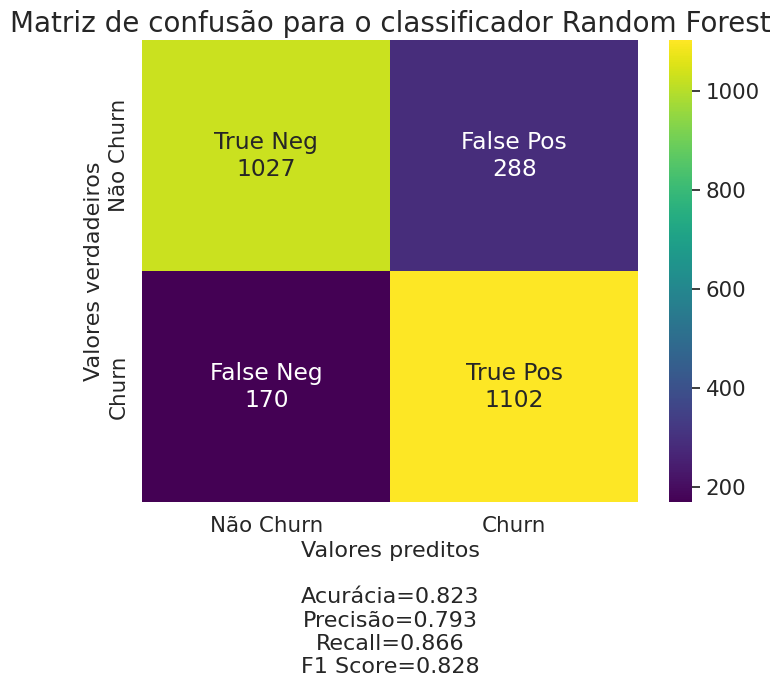

In [16]:
labels = ["True Neg","False Pos","False Neg","True Pos"]  # Labels for the confusion matrix
categories = ["Não Churn", "Churn"]  # Categories for the confusion matrix (target classes)

# Plot confusion matrix with custom labels and categories
plot_matrix_confusion(y_test,
                      y_pred,
                      group_names=labels,
                      categories=categories,
                      figsize=(8, 6),
                      title="Matriz de confusão para o classificador Random Forest")


In [17]:
print(f"Training accuracy: {rforest.score(x_train, y_train) * 100:.2f}%")  # Checking training accuracy

Training accuracy: 84.80%


It can be seen that recall and other metrics increased with the optimized model.

<h4>Before optimization</h4>

|    | Model          | Training Accuracy | Test Accuracy | Precision | Recall | F1-Score |
|---:|:---------------|------------------:|--------------:|----------:|-------:|---------:|
|  0 | random forest  |              0.81 |          0.80 |      0.77 |   0.85 |     0.81 |




<h4>After optimization</h4>

|    | Model          | Training Accuracy | Test Accuracy | Precision | Recall | F1-Score |
|---:|:---------------|------------------:|--------------:|----------:|-------:|---------:|
|  0 | random forest  |              0.85 |          0.82 |      0.79 |   0.86 |     0.83 |


This way, we were able to create a well-optimized model and present it to Alura Vocing.